Simplex query for Peacocks.
Derived from matlab code: poly_query_peacock.mlx

In [3]:
from pathlib import Path
# Load the softmax encodings of the data

from sisap2023.utils.mirflickr import load_mf_encodings

smData = load_mf_encodings(Path('/Volumes/Data/mf_resnet50_softmax'))

# Load the data

allData = load_mf_encodings(Path("/Volumes/Data/mf_dino2")) # load encodings

from simcoder.similarity import l1_norm

allData = l1_norm(allData)

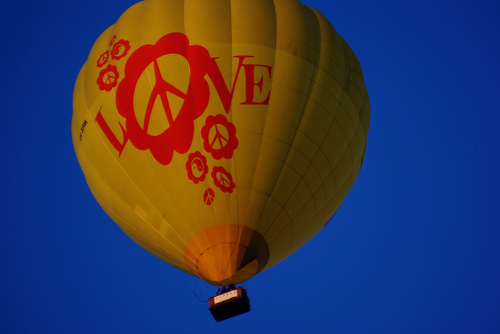

In [4]:
# Get the peacock at index 

from sisap2023.utils.mirflkr import get_mf_image

# 678   a balloon
# 67431 better balloon
# 689898; better balloon
# 74485; # red Virgin balloon

q0 = 990093 # yellow baloon

# The matlab query points - 74485	601442	736646

# the results from matlab: 744865 401614 990093 601442  565107  586042  715357  736646  941757  458302  951695
# 112045  683035  577581  576092  630161  600658  498312  123531


get_mf_image(q0)

In [6]:
from matplotlib import pyplot as plt

def imShow( image ):
    # plt.title(Image title")
    #plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")

    fig = plt.figure(figsize = (1,1)) # in inches!
    plt.axis('off')
    plt.imshow(image) # figsize=(640/80,640/80), dpi=80)
    plt.show()

In [7]:
from sisap2023.utils.distances import getDists

dists = getDists(q0,allData)
closest_indices = np.argsort(dists) # the closest images to the query
poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query
best_100_for_one = closest_indices[0:100]

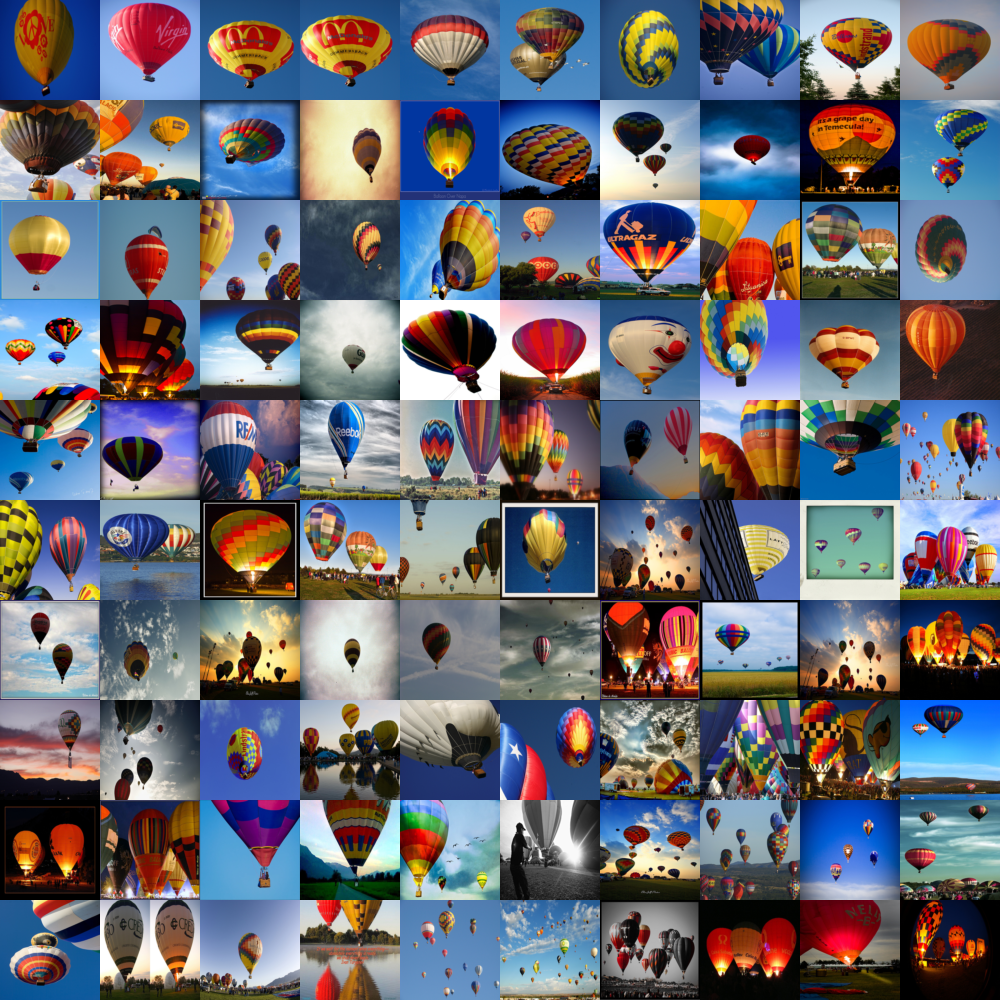

In [9]:
# These are the best images best on lowest average distance from the queries

from sisap2023.utils.mirflickr import make_mf_image_grid

make_mf_image_grid(best_100_for_one,10,10,100,100)



In [10]:
count = 1
for index in best_100_for_one:
    print( index, end='   ' )
    if count % 10 == 0:
        print()
    count = count + 1

990093   74485   854117   854169   125900   367385   915895   475510   600658   565107   
121234   334142   123531   442568   48100   746159   509582   490300   561315   578592   
736646   533016   827338   264627   124680   577870   586047   223581   732911   598060   
21328   581948   689898   161160   562555   586042   112045   44439   728980   498312   
67431   382910   471767   572651   359284   466627   438063   126659   293385   442011   
659640   987860   196762   739129   715204   278522   982901   465006   247944   588171   
709353   401400   981909   432201   598535   265239   722105   657179   981142   510069   
440703   375066   718262   155207   988732   509760   419322   451306   18522   986867   
897025   723215   951695   676446   140857   124304   981772   987655   979462   460037   
63956   465003   443674   62093   916534   11242   417677   572416   458302   46803   


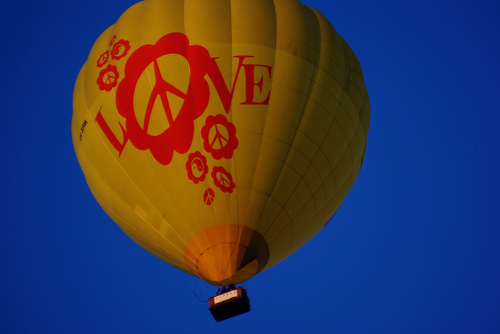

In [11]:
# yellow baloons

get_mf_image(990093)  

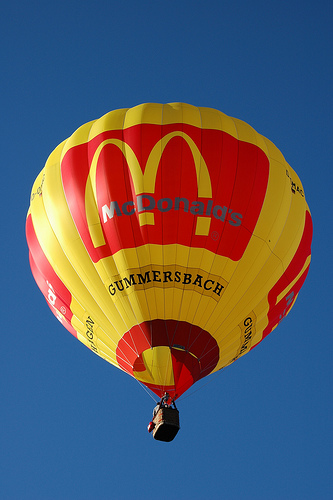

In [ ]:
get_mf_image(854117)


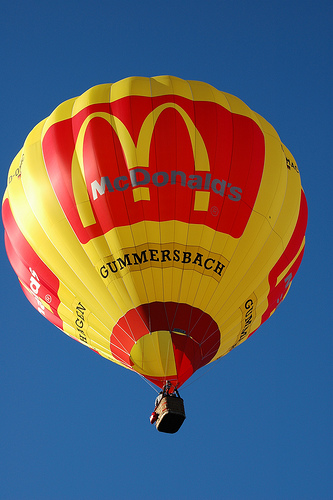

In [ ]:
get_mf_image(854169)


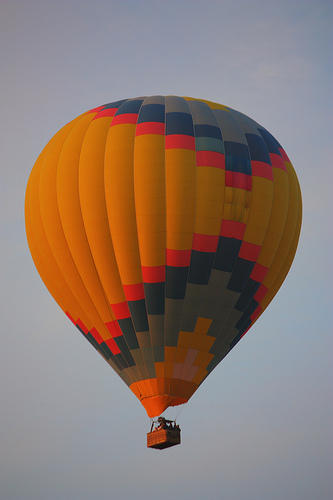

In [ ]:
get_mf_image(565107)


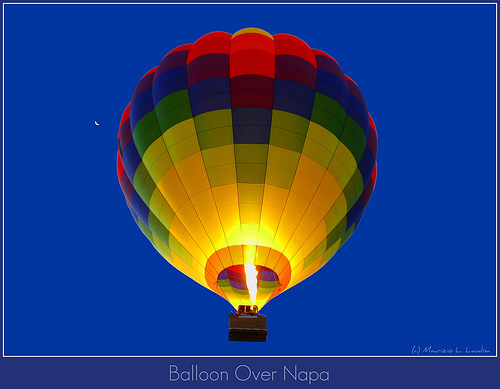

In [ ]:

get_mf_image(48100)

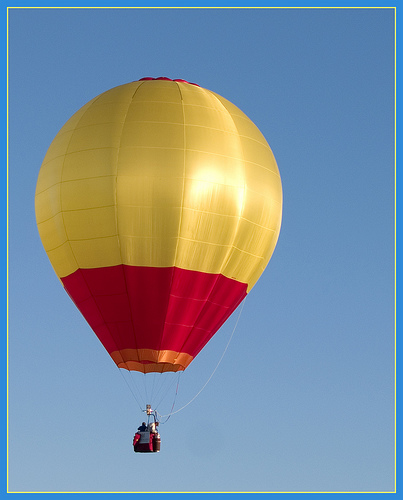

In [ ]:
get_mf_image(736646)

In [12]:
# The mostly yellow ones
yellow_indices = [854117, 854169, 565107, 48100, 736646]
poly_query_data = allData[yellow_indices]

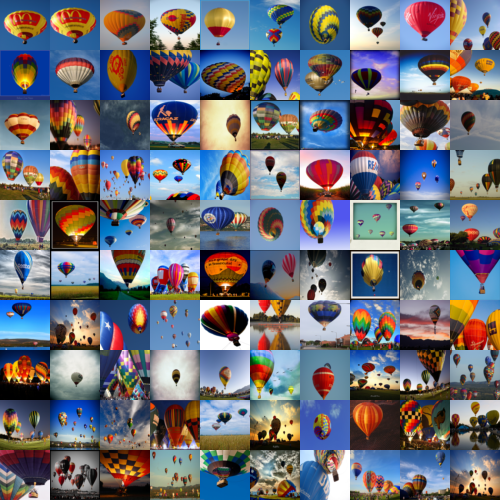

In [13]:
import numpy as np
from sisap2023.metrics.msedOO import msedOO

base = msedOO(poly_query_data)
complexities = base.msed(allData)
complexities = complexities.flatten()   # <<< these are all matrices of matrices shouldn't be.
indices = np.argsort(complexities)      # lowest is first
top_100 = indices[0:100]
make_mf_image_grid(top_100,10,10,50,50)

In [ ]:
import math 
from sisap2023.metrics.euc import euc_scalar

from simcoder.nsimplex import NSimplex
import numpy as np

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i];                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec));
        dists[i] = euc_scalar(pr,perfPoint)

    return dists


In [ ]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euc_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [ ]:
# Fetch the data and whole-set distances for the extra query objects
# fc6_poly_queries is the FC6 data for the queries we have chosen - not needed
# poly_query_distances is the distances from the queries to the all data 1000000,6

num_poly_queries = len(poly_query_indexes)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = getDists(poly_query_indexes[i],allData) 


### Simplex Projection

First calculate the distances from the queries to all data as we will be needing them again

In [ ]:
nsimp = NSimplex()
nsimp.build_base(inter_pivot_distances,False)
# print(xx._base.shape)
# print(xx._base)
# print(inter_pivot_distances.shape)
# print(inter_pivot_distances)

In [ ]:
# Next, find last coord from the simplex formed by 6 query points

all_apexes = nsimp._get_apex(nsimp._base,np.transpose(poly_query_distances))
altitudes = all_apexes[:,num_poly_queries -1] # the heights of the simplex - last coordinate



AssertionError: Base size and number of distances should match, found 5 and 6)

[0.         0.         0.         0.         0.         0.01727188
 0.02090945 0.02150306 0.02275389 0.02278828 0.02391578 0.02394312
 0.02410879 0.02439383 0.0251407  0.0251725  0.02557729 0.02593434
 0.02629629 0.02655196 0.02718073 0.02746679 0.02757251 0.02760033
 0.02760918 0.02764083 0.0276908  0.0277729  0.02807618 0.02848996
 0.02900011 0.02942576 0.02944677 0.02968283 0.02980623 0.03008422
 0.03043981 0.03088154 0.03091108 0.03099516 0.03099807 0.03099979
 0.03108627 0.03114441 0.03120977 0.03134019 0.03150012 0.03165139
 0.03177452 0.03178614 0.03232882 0.0324622  0.03248474 0.03252437
 0.0328076  0.03284826 0.03295581 0.03298318 0.03301357 0.03303302
 0.0331264  0.03314312 0.03320131 0.03324223 0.03330873 0.03338926
 0.03352582 0.03357192 0.03373186 0.03385418 0.03386454 0.03397044
 0.03410188 0.03417939 0.03419873 0.03452309 0.03483281 0.03483503
 0.03494925 0.03496575 0.03514726 0.03525057 0.03529598 0.03582896
 0.03587631 0.03622529 0.03636822 0.03643195 0.03653086 0.0365

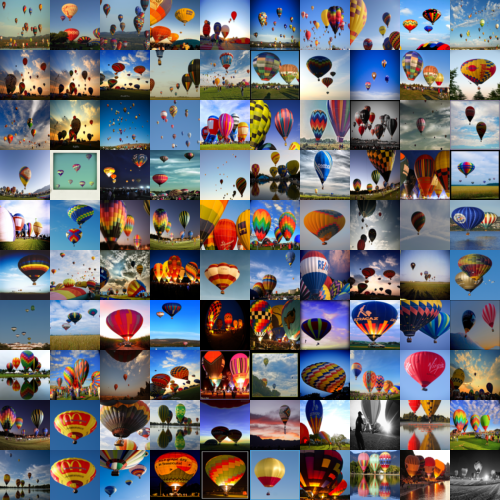

In [ ]:
closest_indices = np.argsort(altitudes) # the closest images to the perfect point

best_100_for_simplex = closest_indices[0:100]

make_mf_image_grid(best_100_for_simplex,10,10,50,50)

In [ ]:
# Now want to report results the total count in the category

from sisap2023.utils.count_cats import count_number_in_cat_gt_thresh 
from sisap2023.utils.count_cats import count_number_in_results_in_cat

encodings_for_best_100_single = softmax_encodings[best_100_for_one] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,balloon_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = softmax_encodings[best_100_for_simplex] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,balloon_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = count_number_in_results_in_cat(balloon_category,0.9,best_100_for_one,softmax_encodings)
print("Total with thresh better than 0.9 single query : ", res)

res = count_number_in_results_in_cat(balloon_category,0.9,best_100_for_simplex,softmax_encodings)
print("Total with thresh better than 0.9 poly query : ", res)

Total peacock sum for single query best 100:  84.09667855453304
Total peacock sum for poly query best 100:  89.02192878986898
Total with thresh better than 0.9 single query :  77
Total with thresh better than 0.9 poly query :  82
